# Stock prices forecasting with LSTM
## 1. Import libraries

In [2]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
import datetime as dt
import plotly.graph_objects as go


from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Stock apis
from polygon import RESTClient

import constants as c

2023-03-14 10:07:48.309749: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2. Preprocessing

In [3]:
# Get data from api
client = RESTClient(api_key=c.POLY_APIKEY)
ticker = "AAPL"

# List Aggregates (Bars)
bars = client.get_aggs(ticker=ticker, multiplier=1, timespan="day", from_="2022-03-01", to="2023-03-31")
df = pd.DataFrame(bars)
df['date'] = pd.to_datetime(df['timestamp'], unit='ms')
df['change'] = df['close'] - df['open']
# df

fig = go.Figure(data=[go.Candlestick(x=df['date'],
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'])])

fig.show()

df

,open,high,low,close,volume,vwap,timestamp,transactions,otc,date,change
0,164.695,166.6000,161.9700,163.20,83468865.0,164.1600,1646110800000,749653,None,2022-03-01 05:00:00,-1.495
1,164.390,167.3600,162.9500,166.56,79724750.0,165.8095,1646197200000,668260,None,2022-03-02 05:00:00,2.170
2,168.470,168.9100,165.5500,166.23,76678441.0,166.9180,1646283600000,651764,None,2022-03-03 05:00:00,-2.240
3,164.490,165.5500,162.1000,163.17,83819592.0,163.3980,1646370000000,743696,None,2022-03-04 05:00:00,-1.320
4,163.360,165.0200,159.0400,159.30,96418845.0,161.4026,1646629200000,847057,None,2022-03-07 05:00:00,-4.060
...,...,...,...,...,...,...,...,...,...,...,...
254,153.785,156.3000,153.4600,153.83,87558028.0,154.6895,1678078800000,691990,None,2023-03-06 05:00:00,0.045
255,153.700,154.0299,151.1300,151.60,56136378.0,152.2768,1678165200000,496631,None,2023-03-07 05:00:00,-2.100
256,152.810,153.4700,151.8300,152.87,47204791.0,152.6973,1678251600000,405203,None,2023-03-08 05:00:00,0.060
257,153.559,154.5350,150.2250,150.59,53833122.0,152.4689,1678338000000,480909,None,2023-03-09 05:00:00,-2.969


In [12]:
# Drop all columns except for closing price and date (index)
close_df = df[['date', 'close']].set_index('date')
close_df

,close
date,
2022-03-01 05:00:00,163.20
2022-03-02 05:00:00,166.56
2022-03-03 05:00:00,166.23
2022-03-04 05:00:00,163.17
2022-03-07 05:00:00,159.30
...,...
2023-03-06 05:00:00,153.83
2023-03-07 05:00:00,151.60
2023-03-08 05:00:00,152.87


In [16]:
# Prepare training set
train_df = close_df['2022-03-01':'2022-12-30']

# Normalise data
scaler = MinMaxScaler(feature_range=(0,1))      # Explore using StandardScaler instead of MinMaxScaler in the future
scaled_data = scaler.fit_transform(train_df['close'].values.reshape(-1,1))

# Number of days to base prediction on:
N_PRED_DAYS = 50

x_train, y_train = [], []

for i in range(len(scaled_data) - N_PRED_DAYS):
    x_train.append(scaled_data[i:i+N_PRED_DAYS, 0])
    y_train.append(scaled_data[i+N_PRED_DAYS, 0])


x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

x_train, y_train

(array([[[0.70219199],
         [0.76568405],
         [0.75944822],
         ...,
         [0.59032502],
         [0.49168556],
         [0.53798186]],
 
        [[0.76568405],
         [0.75944822],
         [0.70162509],
         ...,
         [0.49168556],
         [0.53798186],
         [0.38662132]],
 
        [[0.75944822],
         [0.70162509],
         [0.62849584],
         ...,
         [0.53798186],
         [0.38662132],
         [0.31216931]],
 
        ...,
 
        [[0.30933485],
         [0.33465608],
         [0.33673469],
         ...,
         [0.11696901],
         [0.10997732],
         [0.07539683]],
 
        [[0.33465608],
         [0.33673469],
         [0.32785336],
         ...,
         [0.10997732],
         [0.07539683],
         [0.        ]],
 
        [[0.33673469],
         [0.32785336],
         [0.40117158],
         ...,
         [0.07539683],
         [0.        ],
         [0.06746032]]]),
 array([0.38662132, 0.31216931, 0.39814815, 0.36848073,

## 3. Build LSTM model

In [6]:
def LSTM_model():
    
    model = Sequential()
    
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1],1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=1))
    
    return model

## 4. Training

In [32]:
model = LSTM_model()
model.summary()
model.compile(optimizer='adam', loss='mean_squared_error')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50, 50)            10400     
                                                                 
 dropout_3 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_4 (LSTM)               (None, 50, 50)            20200     
                                                                 
 dropout_4 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [37]:
checkpointer = ModelCheckpoint(filepath = 'weights_best.hdf5', 
                               verbose = 2, 
                               save_best_only = True,
                               monitor='loss'
                               )

hist = model.fit(x_train, 
          y_train, 
          epochs=35, 
          batch_size = 32,
          callbacks = [checkpointer])



Epoch 1/35
5/6 [========================>.....] - ETA: 0s - loss: 0.0094
Epoch 1: loss improved from inf to 0.00935, saving model to weights_best.hdf5
6/6 [==============================] - 0s 45ms/step - loss: 0.0094
Epoch 2/35
5/6 [========================>.....] - ETA: 0s - loss: 0.0108
Epoch 2: loss did not improve from 0.00935
6/6 [==============================] - 0s 41ms/step - loss: 0.0109
Epoch 3/35
5/6 [========================>.....] - ETA: 0s - loss: 0.0115
Epoch 3: loss did not improve from 0.00935
6/6 [==============================] - 0s 37ms/step - loss: 0.0115
Epoch 4/35
5/6 [========================>.....] - ETA: 0s - loss: 0.0131
Epoch 4: loss did not improve from 0.00935
6/6 [==============================] - 0s 37ms/step - loss: 0.0130
Epoch 5/35
5/6 [========================>.....] - ETA: 0s - loss: 0.0090
Epoch 5: loss improved from 0.00935 to 0.00893, saving model to weights_best.hdf5
6/6 [==============================] - 0s 42ms/step - loss: 0.0089
Epoch 6/35


## 5. Predictions

In [38]:
# Prepare test dataset (2023 to end)
test_df = close_df['2023-01-01':]
actual_prices = test_df['close'].values

model_inputs = close_df[len(train_df) - N_PRED_DAYS:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

In [39]:
x_test = []

for i in range(len(model_inputs) - N_PRED_DAYS):
    x_test.append(model_inputs[i:i+N_PRED_DAYS, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

2/2 [==============================] - 1s 12ms/step


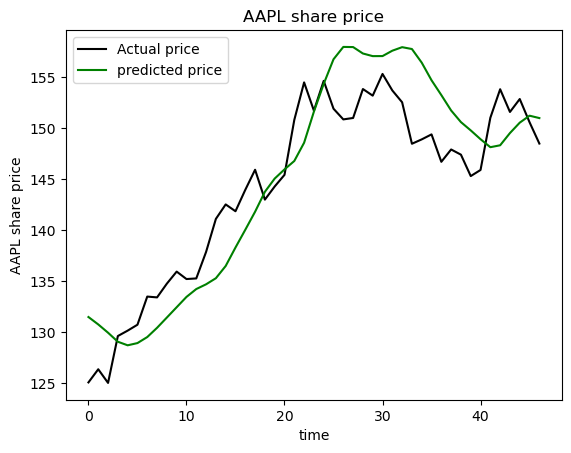

In [40]:
# Plot predicted prices
plt.plot(actual_prices, color='black', label=f"Actual price")
plt.plot(predicted_prices, color= 'green', label=f"predicted price")
plt.title("AAPL share price")
plt.xlabel("time")
plt.ylabel("AAPL share price")
plt.legend()
plt.show()

In [41]:
# Predict next day
real_data = [model_inputs[len(model_inputs)+1 - N_PRED_DAYS:len(model_inputs+1),0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"prediction: {prediction}")

1/1 [==============================] - 1s 738ms/step
prediction: [[149.90587]]
